In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/aa_nn_project/data.zip", 'r') as zObject:
    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content/drive/MyDrive/aa_nn_project/Data")

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from torch import nn
import albumentations as A
# import torchsummary
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

torch.cuda.empty_cache()

BS=16
LR=0.00005
epochs=20
IS=256
D='cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}

dir_path='/content/drive/MyDrive/aa_nn_project/Data'
train_dir_path='/content/drive/MyDrive/aa_nn_project/Data/train'
train_img_paths = sorted(os.listdir('/content/drive/MyDrive/aa_nn_project/Data/train/images'))
train_target_paths = sorted(os.listdir('/content/drive/MyDrive/aa_nn_project/Data/train/labels'))

val_dir_path='/content/drive/MyDrive/aa_nn_project/Data/valid'
val_img_paths = sorted(os.listdir('/content/drive/MyDrive/aa_nn_project/Data/valid/images'))
val_target_paths = sorted(os.listdir('/content/drive/MyDrive/aa_nn_project/Data/valid/labels'))

In [17]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

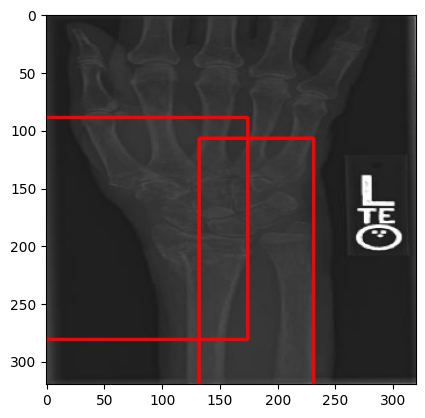

In [18]:
idx=random.randint(0,100)
# idx=0
ip=os.path.join(train_dir_path,'images',train_img_paths[idx])
tp=os.path.join(train_dir_path,'labels',train_target_paths[idx])

image=cv2.imread(ip)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(320,320))

file=open(tp,'r')
target=list(map(float,file.read().split()))[1:]

a=0
while a<len(target):
    bbox=target[a:a+4]
    if len(bbox)==4:
        x,y,w,h=bbox[0], bbox[1], bbox[2], bbox[3]
        xmin,ymin,xmax,ymax=unconvert(320,320,x,y,w,h)
        sp,ep=(xmin,ymin),(xmax,ymax)
        image=cv2.rectangle(image,sp,ep,(255,0,0),2)
    a+=4

plt.imshow(image)
plt.show()

In [19]:
augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

In [20]:
class FractureData(torch.utils.data.Dataset):

    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])

        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape

        file=open(tp,'r')
        target=list(map(float,file.read().split()))

        try:
            label=[target.pop(0)]
            bbox=[]
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)

            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)

        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()

        annot={'boxes':bbox,'labels':label}

        return image, annot

    def collate_fn(self,batch):
        return tuple(zip(*batch))

In [21]:
trainset=FractureData(train_dir_path, train_img_paths, train_target_paths, augs)
valset=FractureData(val_dir_path, val_img_paths, val_target_paths, augs)

trainloader=torch.utils.data.DataLoader(trainset,batch_size=BS,collate_fn=trainset.collate_fn)
valloader=torch.utils.data.DataLoader(valset,batch_size=BS,collate_fn=valset.collate_fn)

print(f'Training Data:- {len(trainset)} images divided into {len(trainloader)} batches')

Training Data:- 3631 images divided into 227 batches


In [22]:
for image,target in trainloader:
    break

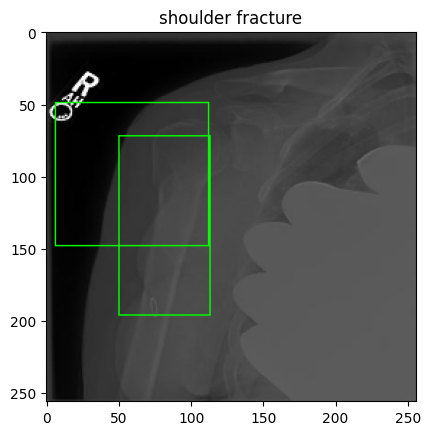

In [23]:
idx=random.randint(0,len(image))
img, tar = image[idx].permute(1,2,0).numpy(), target[idx]

for bbox in tar['boxes']:
    xmin,ymin,xmax,ymax=bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
    sp,ep=(xmin,ymin),(xmax,ymax)
    cv2.rectangle(img,sp,ep,(0,255,0),1)

plt.imshow(img)
plt.title(l2c[tar['labels'][0].item()])
plt.show()

### SSD Model with VGG-16 Backbone

In [24]:
import torchvision
from torchvision.models.detection.ssd import SSD

model=torchvision.models.detection.ssd300_vgg16(preTrained=True)

for param in model.parameters():
    param.requires_grad = True

num_default_boxes = len(model.anchor_generator.aspect_ratios[0]) * len(model.anchor_generator.scales)



model.classification_headers = nn.ModuleList([
    nn.Conv2d(256, num_classes * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(512, num_classes * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(1024, num_classes * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(512, num_classes * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(256, num_classes * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(256, num_classes * num_default_boxes, kernel_size=3, padding=1)
])

model.regression_headers = nn.ModuleList([
    nn.Conv2d(256, 4 * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(512, 4 * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(1024, 4 * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(512, 4 * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(256, 4 * num_default_boxes, kernel_size=3, padding=1),
    nn.Conv2d(256, 4 * num_default_boxes, kernel_size=3, padding=1)
])

# Add custom layers on top of the pre-trained model
custom_layers = nn.Sequential(
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

# Replace the final classification layer with custom layers
model.classifier = custom_layers

model.to(D);

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:04<00:00, 114MB/s]


In [25]:
def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0

    for images, targets in tqdm(dataloader):
        image=[i.to(D) for i in images]
        target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]

        opt.zero_grad()
        losses=model(image,target)
        loss=sum(loss for loss in losses.values())
        loss.backward()
        opt.step()

        train_loss+=loss
    return train_loss/len(dataloader)

def evalarc(model, dataloader):
    model.train()
    val_loss=0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            image=[i.to(D) for i in images]
            target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]

            losses=model(image,target)
            loss=sum( loss for loss in losses.values() )

            val_loss+=loss
    return val_loss/len(dataloader)

In [26]:
best_val_loss=np.Inf

opt=torch.optim.Adam(model.parameters(),lr=LR)

for i in range(epochs):
    train_loss=trainarc(model,trainloader,opt)
    val_loss=evalarc(model,valloader)

    print(f"Epochs: {i+1}/{epochs}:- Trainloss: {train_loss}, Valloss: {val_loss}")

    if val_loss<best_val_loss:
        torch.save(model.state_dict(),'/content/drive/MyDrive/aa_nn_project/Trained_Models/model.pt')
        print("Model Updated")
        best_val_loss=val_loss

torch.save(model.state_dict(),'/content/drive/MyDrive/aa_nn_project/Trained_Models/FullyTrainedModel.pt')
print("Fully Trained Model Saved")
print(f"Done. Best Val Loss: {best_val_loss}")

100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epochs: 1/20:- Trainloss: 8.617959022521973, Valloss: 5.539527416229248
Model Updated


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epochs: 2/20:- Trainloss: 5.178427696228027, Valloss: 5.27472448348999
Model Updated


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epochs: 3/20:- Trainloss: 4.902164936065674, Valloss: 5.176209926605225
Model Updated


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epochs: 4/20:- Trainloss: 4.752063751220703, Valloss: 5.1848673820495605


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epochs: 5/20:- Trainloss: 4.619128227233887, Valloss: 5.179241180419922


100%|██████████| 22/22 [00:21<00:00,  1.05it/s]


Epochs: 6/20:- Trainloss: 4.468706130981445, Valloss: 5.255965232849121


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epochs: 7/20:- Trainloss: 4.326418399810791, Valloss: 5.256786823272705


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epochs: 8/20:- Trainloss: 4.24553918838501, Valloss: 5.238612174987793


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epochs: 9/20:- Trainloss: 4.153921127319336, Valloss: 5.357241630554199


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epochs: 10/20:- Trainloss: 4.0041327476501465, Valloss: 5.316021919250488


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epochs: 11/20:- Trainloss: 3.829266309738159, Valloss: 5.256852626800537


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epochs: 12/20:- Trainloss: 3.6338083744049072, Valloss: 5.391633987426758


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epochs: 13/20:- Trainloss: 3.4690282344818115, Valloss: 5.374041557312012


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epochs: 14/20:- Trainloss: 3.278435230255127, Valloss: 5.7493462562561035


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epochs: 15/20:- Trainloss: 3.23795747756958, Valloss: 5.678595066070557


100%|██████████| 22/22 [00:21<00:00,  1.05it/s]


Epochs: 16/20:- Trainloss: 3.1137197017669678, Valloss: 5.652480602264404


100%|██████████| 22/22 [00:21<00:00,  1.05it/s]


Epochs: 17/20:- Trainloss: 3.013366222381592, Valloss: 5.497837543487549


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epochs: 18/20:- Trainloss: 2.9145724773406982, Valloss: 5.441372871398926


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epochs: 19/20:- Trainloss: 2.610175609588623, Valloss: 5.290859222412109


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epochs: 20/20:- Trainloss: 2.5450072288513184, Valloss: 5.6022515296936035
Fully Trained Model Saved
Done. Best Val Loss: 5.176209926605225


In [28]:
test_dir_path='/content/drive/MyDrive/aa_nn_project/Data/test'
test_img_paths = sorted(os.listdir('/content/drive/MyDrive/aa_nn_project/Data/test/images'))
test_target_paths = sorted(os.listdir('/content/drive/MyDrive/aa_nn_project/Data/test/labels'))

testset=FractureData(test_dir_path, test_img_paths, test_target_paths, augs)

49


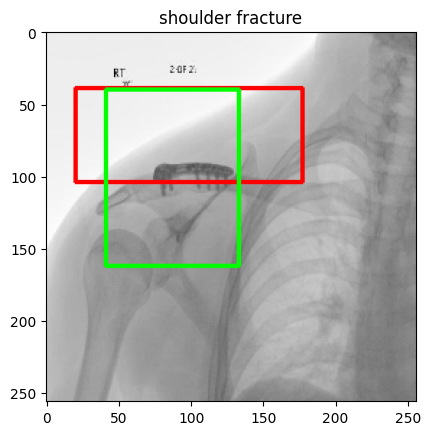

In [29]:
idx=random.randint(0,len(testset)-1)
print(idx)
test_img,test_tar=testset[idx]

model.eval()
pred=model(test_img.unsqueeze(0).to(D))
# pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
label=pred[0]['labels'][0].item()

Txmin,Tymin,Txmax,Tymax=test_tar['boxes'][0].tolist()

image=cv2.rectangle(test_img.permute(1,2,0).numpy(),(xmin,ymin),(xmax,ymax),(255,0,0),2)
image=cv2.rectangle(image,(Txmin,Tymin),(Txmax,Tymax),(0,255,0),2)
plt.imshow(image)
plt.title(l2c[label])
plt.show()